In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from Neuron_analysis_tool.utils import video_player
from pathlib import Path
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON mechanisms not found in /ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/x86_64/special.


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


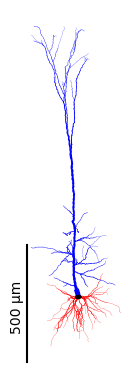

In [3]:
_,_,_ = analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90)

## create a somaticentric view card 

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

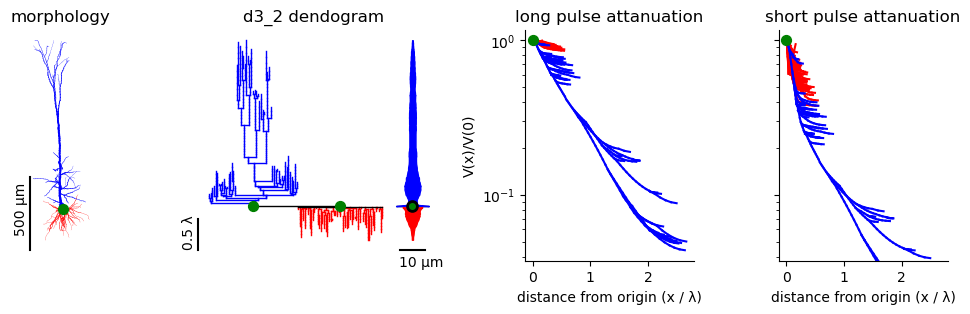

In [4]:
analyser.create_card(theta=-90, diam_factor=0.5, cable_factor=3)

## create a spasific segment centric view card

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

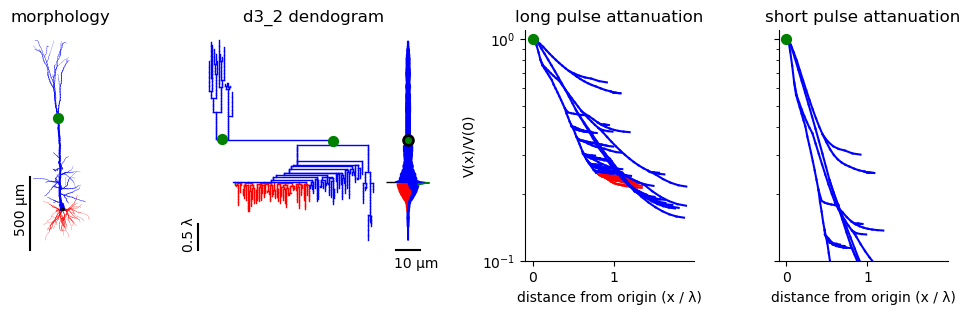

In [5]:
analyser.create_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5, cable_factor=3)

error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]


(<Figure size 1200x300 with 3 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'dendogram'}>,
        <AxesSubplot:title={'center':'$d^{3/2}$ equivalent cable'}, ylabel='distance (λ)'>],
       dtype=object))

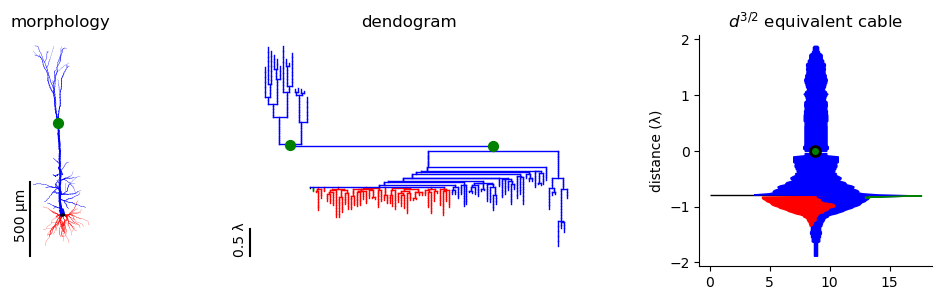

In [6]:
analyser.create_morpho_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5)

## defining a new protocol to record, protocol is a function that gets the cell and the start segment (in the case you intrested of using a spasific one), and runs a simulation.
### the function muyst return the tstop of the simulation, the delay/time to start, the duration of the activation, the amplitude, and a dictionary with extra stuff you want to save for to the end of the computation of this video

In [7]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 550
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return 300, {}

In [8]:
records, extra = analyser.record_protocol(protocol=Ca_spike_protocol, 
                                          record_names=['v', 'gCa_LVAst_Ca_LVAst'], 
                                          compute_more_condunctances=True)


the file name is taken, delete the file? (Y, N)Y
error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]
error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]
duration= 12.499999999997268
Moviepy - Building video videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4.
Moviepy - Writing video videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/voltage_and_gCa_LVAst_on_morph.mp4


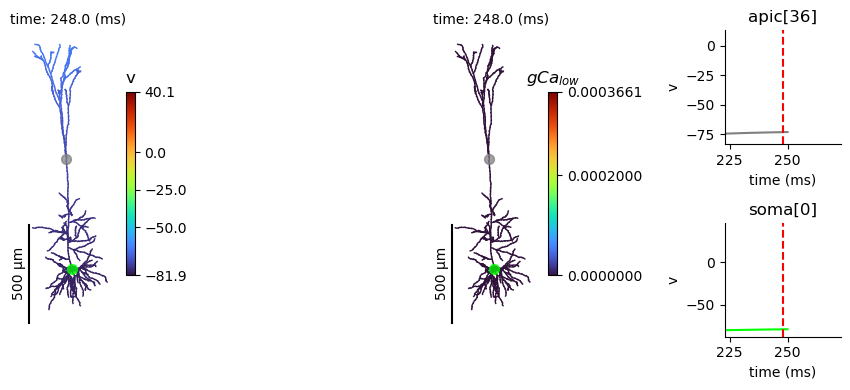

In [9]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
plt.tight_layout()
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.4])
ax_morph = fig.add_subplot(gs[:, 0])
ax_morph2 = fig.add_subplot(gs[:, 1])
ax_soma_voltage = fig.add_subplot(gs[1, 2])
ax_hot_spot_voltage = fig.add_subplot(gs[0, 2])
f = lambda: plt.subplots_adjust(wspace=0.6)
f()

seg_to_indicate_dict = dict()
seg_to_indicate_dict[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
seg_to_indicate_dict[list(analyser.cell.apic[36])[-1]] = dict(label='tip', alpha=0.75, color='grey', size=50)

soma_seg = list(analyser.cell.soma[0])[0]
plot_kwargs = [
    dict(ax=ax_morph, seg = soma_seg, records=records.all_records['v'], electrical=False, plot_type='morph', 
         seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270, scale=500),
    
    dict(ax=ax_morph2, seg = soma_seg, records=records.all_records['gCa_LVAst_Ca_LVAst'], electrical=False, 
         plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270, scale=500, 
         bar_name='$gCa_{low}$'),
    
    dict(ax=ax_soma_voltage, seg = soma_seg, records=records.all_records['v'], plot_type='single_record', 
         color='lime'),
    
    dict(ax=ax_hot_spot_voltage, seg = list(analyser.cell.apic[36])[-1], records=records.all_records['v'], 
         plot_type='single_record', color='grey'),
    
              ]
f = lambda: plt.tight_layout()
slow_down_factor=50
videos_folder = 'videos/L5PC/'
video_name = 'voltage_and_gCa_LVAst_on_morph.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast', auto_del=False)
video_player(Path.cwd(), videos_folder+video_name)


### the morphology, dendogram and cable can dance
#### in order to do this you need to make sure to set compute_more_condunctances=True above at the record_protocol function

the file name is taken, delete the file? (Y, N)Y
error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]
duration= 24.999999999994536
Moviepy - Building video videos/L5PC/dancing_morph_and_dendogram.mp4.
Moviepy - Writing video videos/L5PC/dancing_morph_and_dendogram.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/dancing_morph_and_dendogram.mp4


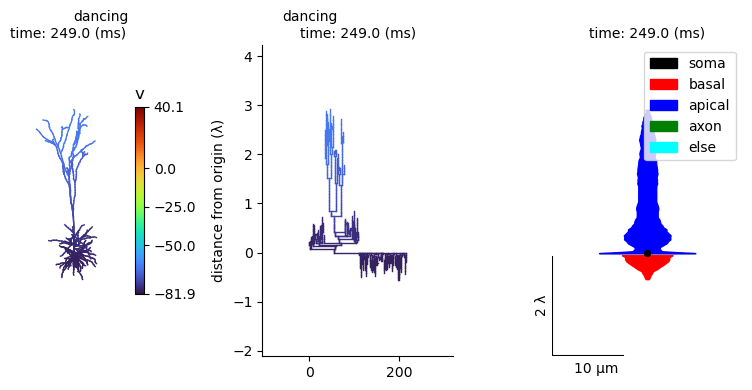

In [10]:
more_conductances_ = extra['more_conductances']

fig, ax = plt.subplots(1,3, figsize=(8,4))
soma_seg = list(analyser.cell.soma[0])[0]

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='morph',
         plot_color_bar=True, theta=270, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[1], seg = soma_seg, records=records.all_records['v'], electrical=True, plot_type='dendogram', 
         plot_color_bar=False, dancing=True, more_conductances_=more_conductances_),
    dict(ax=ax[2], seg = soma_seg, plot_type='cable', cable_type='d3_2',
         factor_e_space=25, records=records.all_records['v'], more_conductances_=more_conductances_, 
         scales=dict(x=10, y=2)),
              ]
f = lambda: plt.tight_layout()
slow_down_factor=100
videos_folder = 'videos/L5PC/'
video_name = 'dancing_morph_and_dendogram.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

# animation = analyser.create_movie_from_rec(fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs)
# animation.ipython_display(fps=10, loop=True, autoplay=True, maxduration=animation.duration+10)

### adding drawing on the video

#### in order to add some drawing on the video you can pass draw_funcs fo each plot. the function gets the time window (start, end) the segments and the elements in the plot (as lists so lines[i] corespond to the segs[i] and the record object you passed as the records of this plot) 

#### here we show a case we indecate the start of injection to the soma (red dot on the top left side of the morphology) and a blue dot at synapse activation at the tuft (blue dot at the same location)

the file name is taken, delete the file? (Y, N)
exit without running


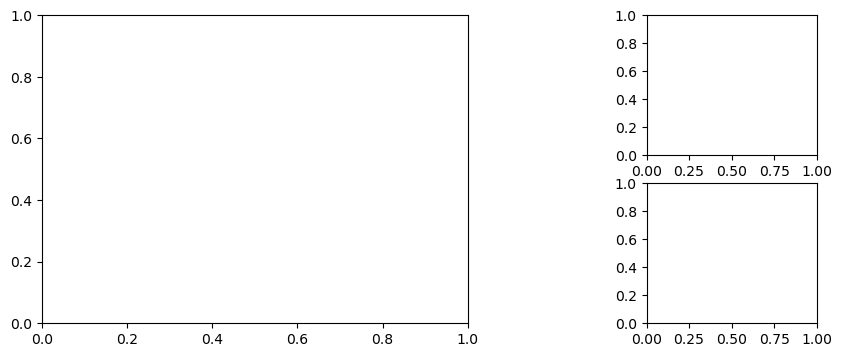

In [11]:
def draw_func1(start_time, end_time, segs, lines, ax, records):
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame

    elements = []
    shift = 40
    if start_time < 100 and end_time >= 100:
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        elements.append(ax.scatter(x_lim[1]-shift, y_lim[1]-shift, color='r', s=100))
    if start_time < 105 and end_time >= 105:
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        elements.append(ax.scatter(x_lim[1]-shift, y_lim[1]-shift, color='b', s=100))
    return elements
    
        
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
plt.tight_layout()
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 0.4])
ax_morph = fig.add_subplot(gs[:, 0])
ax_soma_voltage = fig.add_subplot(gs[1, 1])
ax_hot_spot_voltage = fig.add_subplot(gs[0, 1])
f = lambda: plt.subplots_adjust(wspace=0.6)
f()

seg_to_indicate_dict = dict()
seg_to_indicate_dict[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
seg_to_indicate_dict[list(analyser.cell.apic[36])[-1]] = dict(label='tip', alpha=0.75, color='grey', size=50)

soma_seg = list(analyser.cell.soma[0])[0]
plot_kwargs = [
    dict(ax=ax_morph, seg = soma_seg, records=records.all_records['v'], electrical=False, 
         plot_type='morph', seg_to_indicate_dict=seg_to_indicate_dict,plot_color_bar=True, theta=270, 
         scale=500,  draw_funcs=[draw_func1]),
    dict(ax=ax_soma_voltage, seg = soma_seg, records=records.all_records['v'], plot_type='single_record', 
         color='lime'),
    dict(ax=ax_hot_spot_voltage, seg = list(analyser.cell.apic[36])[-1], records=records.all_records['v'], 
         plot_type='single_record', color='grey'),
    
              ]
f = lambda: plt.tight_layout()
slow_down_factor=100
videos_folder = 'videos/L5PC/'
video_name = 'voltage_on_morph_input_time.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, func_before_run=[f],
                             save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast', auto_del=False)
video_player(Path.cwd(), videos_folder+video_name)


### adding drawing on the video - part 2 adding synapses

#### we can create this draw function inside the protocol running function so they will have acsses to protocol parameters such as synapses activation times or g_NMDA conductance

#### here we show a case we create a protocol of random synaptic activations, on top  of the morphology we can indicate the location of the currently activation of synapses and synapses that show large NMDA activity

In [12]:

def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    #setting exitatory synapse
    netstim = h.NetStim()
    netstim.interval = 400 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 1.5
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def add_isyn(seg, g_GABA=0.0004):
    #setting inhibitory synapse
    netstim = h.NetStim()
    netstim.interval = 500 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 0
    
    GABA = h.Exp2Syn(seg.x, sec=seg.sec)
    GABA_con= h.NetCon(netstim, GABA)
    GABA.e = -100
    GABA.tau1 = 0.2
    GABA.tau2 = 4
    GABA_con.weight[0] = g_GABA
    GABA_con.delay = 0

    return [GABA, GABA_con], netstim


def random_syn_protocol_NMDA_ditact(cell, start_seg):
    # protocol of 5000 exitatory and 200 inhibitory synapses with firing rate of 2 Hz randomly on the morphology tree
    syns = []
    isyns = []
    segs_e = []
    syn_e_times = []
    
    segs_i = []
    syn_i_times = []
    g_NMDA_rec = []
    start_time_= 400
    total_time = 1000+start_time_#1400
    
    number_of_e_syns = 5000
    number_of_i_syns = 2000
    g_max_NMDA=0.0004
    
    amp=0
    e_FR = 2 #Hz
    i_FR = 2 #Hz
    sim_time = total_time-start_time_
    # making sure there are no more then 40 synapses per segment
    valid_segments = []
    for sec in cell.dend:
        for seg in sec:
            valid_segments+=[seg]*40
    for sec in cell.apic:
        for seg in sec:
            valid_segments+=[seg]*40
    # adding synapses to the model
    segs_for_syns = np.random.choice(valid_segments, number_of_e_syns+number_of_i_syns, replace=False)
    for seg in segs_for_syns[:number_of_e_syns]:
        segs_e.append(seg)
        syns.append(add_syn(seg))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*e_FR))) * sim_time + start_time_
        syn_e_times.append(syn_time)
        g_NMDA_rec.append(h.Vector())
        g_NMDA_rec[-1].record(syns[-1][1][0]._ref_g_NMDA)

    for seg in segs_for_syns[-number_of_i_syns:]:
        segs_i.append(seg)
        isyns.append(add_isyn(seg))
        syn_time = np.random.rand(int(np.ceil(sim_time/1000.0*i_FR))) * sim_time + start_time_
        syn_i_times.append(syn_time)

    #function to insert synapse time to neuron
    def event_setter():
        for syn, times in zip(syns, syn_e_times):
            for t in times:
                syn[0][1].event(t) #AMPA netcon
                syn[1][1].event(t) #NMDA netcon          
        for syn, times in zip(isyns, syn_i_times):
            for t in times:
                syn[0][1].event(t) #GABA netcon
    
    # this function is return to the movie maker and is called every frame generation, than one can add stuff to the frame.
    # you must return all the new created items, so the function can call .remove() to remove this items in the next frame
    def scatter_active_synapses_location(start_time, end_time, segs, lines, ax, records):
        #function that draw the location of the current active synapse location (red for exitetion blue for inhibition)
        elements = []
        start_time+=start_time_
        end_time+=start_time_
        
        for seg, syn, times in zip(segs_e, syns, syn_e_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), 
                                                       color='r', alpha=0.75, s=10, label='excitation'))
                        except:
                            pass
        for seg, syn, times in zip(segs_i, isyns, syn_i_times):
            for t in times:
                if t>start_time and t< end_time:
                    if seg in segs:
                        l = lines[segs==seg][0]
                        try:
                            elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), 
                                                       color='b', alpha=0.75, s=10, label='inhibition'))
                        except:
                            pass
        
        return elements
    
    def scatter_large_active_NMDA_synapses_location(start_time, end_time, segs, lines, ax, records):
        #function that draw the location of synapses that there NMDA g is abouve 0.3 of the gmax
        NMDA_present_thresh=0.3
        # extracting g_NMDA records
        for i in range(len( g_NMDA_rec)):
            if not (type(g_NMDA_rec[i]) == np.ndarray):
                g_NMDA_rec[i] = records.extraction_func(g_NMDA_rec[i])
        
        # detact g_NMDA
        elements = []
        time = records.time
        for seg, syn, gNMDA_syn in zip(segs_e, syns, g_NMDA_rec):
            if (gNMDA_syn[np.logical_and(time>start_time, time<=end_time)]>NMDA_present_thresh*g_max_NMDA).sum()>=1:
                if seg in segs:
                    l = lines[segs==seg][0]
                    try:
                        elements.append(ax.scatter(l.get_xdata().mean(), l.get_ydata().mean(), color='cyan', alpha=0.5, s=100, label='NMDA spike'))
                    except:
                        print('error, got:', seg, syn)
                else:
                    print('error, no segment with this name:', seg, syn)
        return elements
        
    h.tstop = total_time
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    fih=h.FInitializeHandler(0, event_setter)
    h.run()
    return start_time_, dict(draw_funcs=[scatter_active_synapses_location, 
                                         scatter_large_active_NMDA_synapses_location])

In [13]:
records, extra = analyser.record_protocol(protocol=random_syn_protocol_NMDA_ditact, record_names=['v'])

In [14]:
   
def set_legend(start_time, end_time, segs, lines, ax, records):
    handles, labels = ax.get_legend_handles_labels() 
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    return []


the file name is taken, delete the file? (Y, N)Y
error in geting morph part from section: L5PCtemplate[0].axon[0]
error in geting morph part from section: L5PCtemplate[0].axon[1]
duration= 100.00000000031287
Moviepy - Building video videos/L5PC/random_synapses_with_NMDA_detection.mp4.
Moviepy - Writing video videos/L5PC/random_synapses_with_NMDA_detection.mp4



Moviepy - Done !
Moviepy - video ready videos/L5PC/random_synapses_with_NMDA_detection.mp4


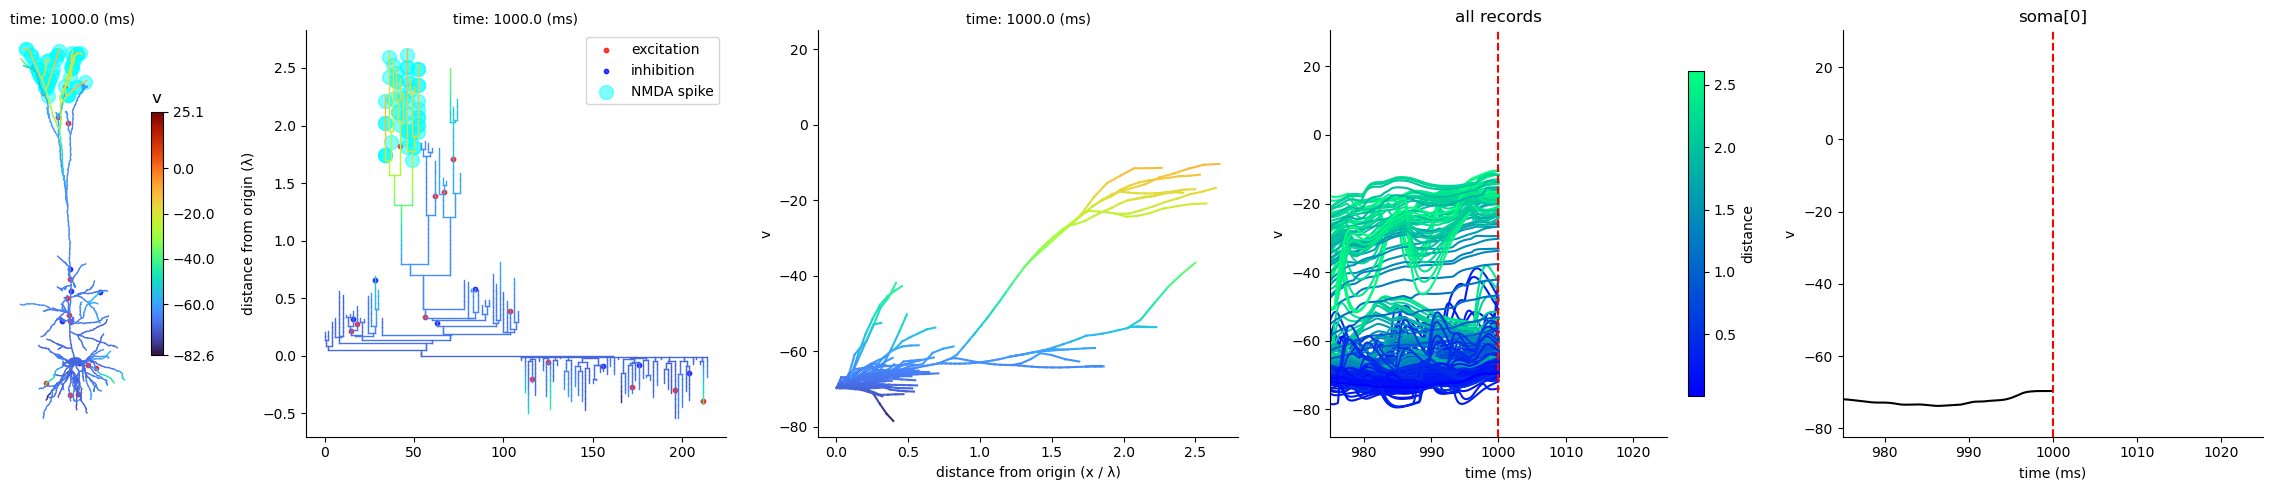

In [16]:
draw_funcs = extra['draw_funcs']
fig, ax = plt.subplots(1, 5, figsize=(25,5))
soma_seg = list(analyser.cell.soma[0])[0]

hot_spot_seg = list(analyser.cell.apic[36])[0]
record_dict = records.all_records['v']

plot_kwargs = [
    dict(ax=ax[0], seg = soma_seg, records=record_dict, electrical=False, plot_type='morph', 
         plot_color_bar=True, theta=-90, draw_funcs=draw_funcs),
    
    dict(ax=ax[1], seg = soma_seg, records=record_dict, electrical=True, plot_type='dendogram', 
         plot_color_bar=False, draw_funcs=draw_funcs+[set_legend]),
    
    dict(ax=ax[2], seg = soma_seg, records=record_dict, electrical=True, plot_type='attenuation'),
    dict(ax=ax[3], seg = soma_seg, records=record_dict, distance_factor=0, plot_every=0.1, 
         plot_type='all_records', color_distance=True, cmap=plt.cm.winter, color_bar_kwarts=dict(shrink=0.8),
         on_title=False, on_ylabel=True),
    
    dict(ax=ax[4], seg = soma_seg, records=record_dict, plot_type='single_record'),
              ]
f = lambda: plt.tight_layout()
slow_down_factor = 100
videos_folder = 'videos/L5PC/'
video_name = 'random_synapses_with_NMDA_detection.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs, 
                             func_before_run=[f], save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')
video_player(Path.cwd(), videos_folder+video_name)

In [1]:
from neuron import gui, h


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [25]:
from neuron import gui, h
import numpy as np

def mRin(cell, is_axon = False):
    if is_axon:        
        start_sec = cell.axon[0]
        start_seg = list(start_sec)[0]
    else:
        start_sec = cell.soma[0]
        start_seg = list(start_sec)[len(list(start_sec))//2]
    imp = h.Impedance(start_seg.x, sec=start_seg.sec)
    imp.loc(start_seg.x, sec=start_seg.sec)

    imp.compute(0)
    return imp.input(start_seg.x, sec=start_seg.sec)
    
def get_rho(cell, is_axon=False):
    # make_passive
    for sec in cell.all:
        mechs = set()
        for seg in sec:
            for mech in seg:
                mechs.add(str(mech))
        for mech in mechs:
            if 'ion' in mech: continue
            if 'pas' == mech: continue            
            sec.uninsert(mech)
    Rin_total = mRin(cell, is_axon=is_axon)
    gin_total = 1.0/Rin_total
    
    if is_axon:
        sec_to_remove_list=[]
        for sec_list in [cell.soma, cell.dend, cell.apic, cell.myelin]:
            for sec in sec_list:
                sec_to_remove_list.append(sec)
    else:
        sec_to_remove_list = cell.soma[0].children()
    for sec in sec_to_remove_list:
        h.delete_section(sec=sec)
    
    Rin_1 = mRin(cell, is_axon=is_axon)
    gin_1 = 1.0/Rin_1
    Rin_2 = 1.0/(gin_total-gin_1)
    rho = (gin_total-gin_1)/gin_1
    return rho, Rin_total, Rin_1, Rin_2

h.load_file("nrngui.hoc")
h.load_file("import3d.hoc")
print('start')
h.load_file("/ems/elsc-labs/segev-i/yoni.leibner/Downloads/HayEtAl2013/models/L5PCbiophys_p14_exemplar.hoc")
print('start2')
h.load_file("/ems/elsc-labs/segev-i/yoni.leibner/Downloads/HayEtAl2013/models/L5PCtemplate.hoc")
cell = h.L5PCtemplate("/ems/elsc-labs/segev-i/yoni.leibner/Downloads/HayEtAl2013/morphologies/cell21.asc")

print(cell)
# print(cell.soma[0].children())
# print(get_rho(cell))
print(get_rho(cell, is_axon=True))



start
start2
L5PCtemplate[18]
(187.9314983049065, 47.463112778959655, 8967.277011543603, 47.715668168593986)


NEURON: Not allowed to uninsert ions at this time k_ion
 near line 0
 {gIhbar_Ih(1.0000000000) = 0.0002442368}
                                         ^
NEURON: Not allowed to uninsert ions at this time ca_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time na_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time k_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time ca_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time na_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time k_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time ca_ion
 near line 0
 ^
NEURON: Not allowed to uninsert ions at this time na_ion
 near line 0
 ^


In [14]:
cell = h.L5PCtemplate("/ems/elsc-labs/segev-i/yoni.leibner/Downloads/HayEtAl2013/morphologies/cell21.asc")


In [16]:
for sec in cell.myelin:
    if sec in cell.all:
        print(sec)
    else:
        print('not in ', sec)

not in  L5PCtemplate[9].myelin[0]


In [11]:
cell.axon[0].nseg

5

In [18]:
cell = h.L5PCtemplate("/ems/elsc-labs/segev-i/yoni.leibner/Downloads/HayEtAl2013/morphologies/cell21.asc")


	-65 
	-65 


In [7]:
len(cell.myelin)

1